| 1flip | 3flip | 5flip | bitFlip |
|-------|-------|-------|---------|
| proba | proba | proba | proba   |
| utilité | utilité | utilité | utilité |
| nb d'utilisation | nb d'utilisation | nb d'utilisation | nb d'utilisation |

Génération 10000: Meilleur score = 933
Génération 20000: Meilleur score = 999
Génération 21129: Meilleur score = 1000
Matrice des opérateurs finale: [{'operator': 'mutation1flip', 'nb_utilisation': 7586, 'cumulative_reward': 426.2000000000279}, {'operator': 'mutation3flip', 'nb_utilisation': 2716, 'cumulative_reward': 59.15000000000089}, {'operator': 'mutation5flip', 'nb_utilisation': 3804, 'cumulative_reward': 133.14999999999344}, {'operator': 'mutationBitFLip', 'nb_utilisation': 7023, 'cumulative_reward': 380.5499999999778}]


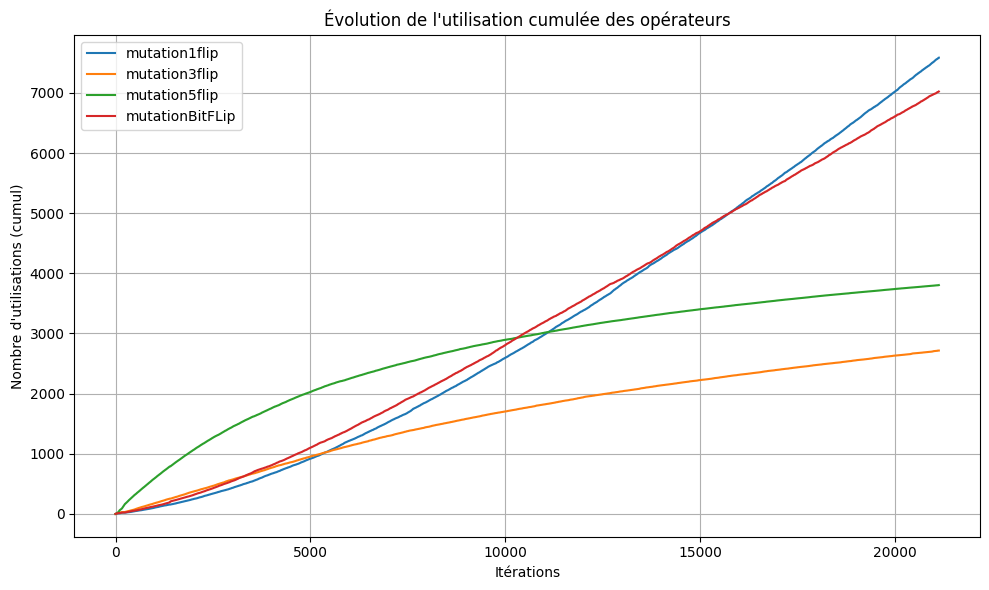

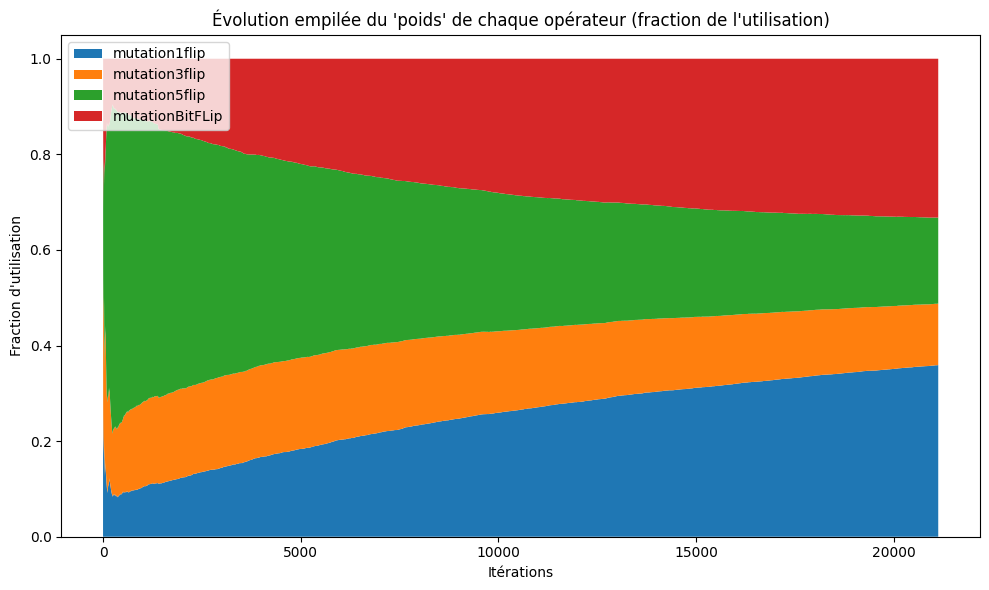

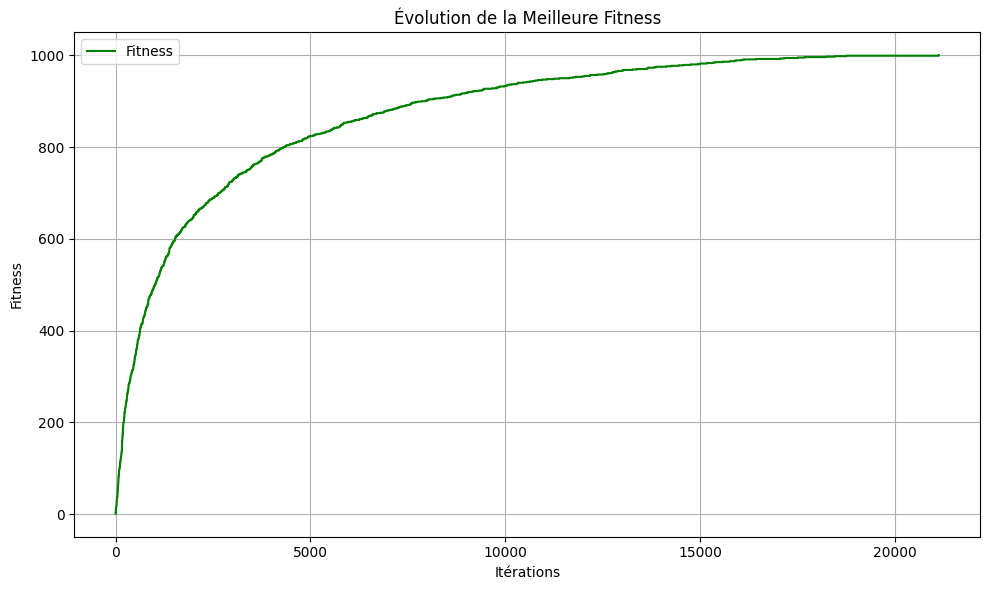

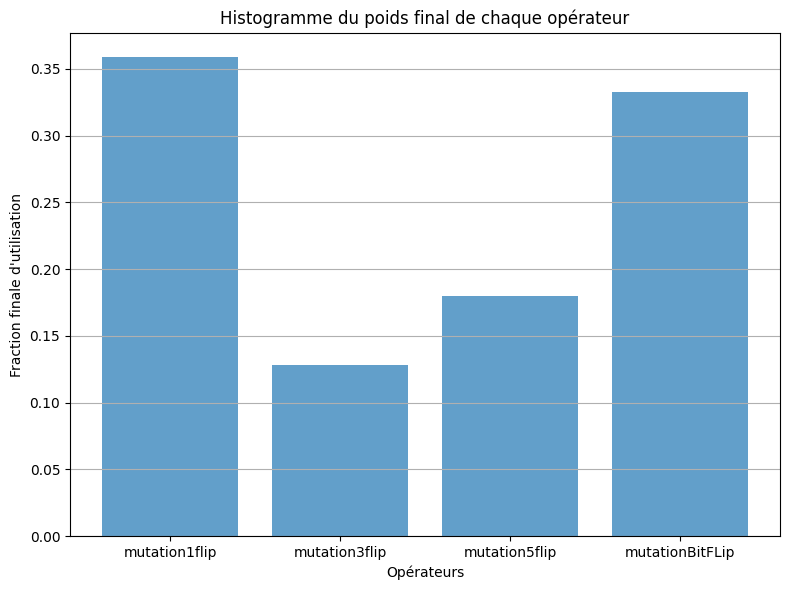

In [5]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

from fitness import Fitness
from randomOneMax import RandomOneMax

# === Paramètres globaux ===
TAILLE_VECTEUR = 1000
TAILLE_POPULATION = 20
MAX_ITER = 30000

# === UCB Operator Matrix ===
# Each operator only stores how many times it was used and its cumulative reward.
operator_matrix = [
    {"operator": "mutation1flip",   "nb_utilisation": 0, "cumulative_reward": 0.0},
    {"operator": "mutation3flip",   "nb_utilisation": 0, "cumulative_reward": 0.0},
    {"operator": "mutation5flip",   "nb_utilisation": 0, "cumulative_reward": 0.0},
    {"operator": "mutationBitFLip", "nb_utilisation": 0, "cumulative_reward": 0.0}
]

def replace_pire(population, new_individual):
    pire_individu = min(population, key=lambda x: Fitness(x).getFitness())
    population.remove(pire_individu)
    population.append(new_individual)

def initialisationPopulation(npop):
    # IMPORTANT: each individual must be unique
    return [[0 for _ in range(TAILLE_VECTEUR)] for _ in range(npop)]
    # Or random initialization:
    # return [[random.randint(0,1) for _ in range(TAILLE_VECTEUR)] for _ in range(npop)]

def selection2Best(population):
    return sorted(population, key=lambda x: Fitness(x).getFitness(), reverse=True)[:2]

def mutation1flip(individual):
    new_individual = individual.copy()
    mutationPoint = random.randint(0, TAILLE_VECTEUR - 1)
    new_individual[mutationPoint] = 1 - new_individual[mutationPoint]
    return new_individual

def mutation3flip(individual):
    new_individual = individual.copy()
    indices = random.sample(range(TAILLE_VECTEUR), 3)
    for idx in indices:
        new_individual[idx] = 1 - new_individual[idx]
    return new_individual

def mutation5flip(individual):
    new_individual = individual.copy()
    indices = random.sample(range(TAILLE_VECTEUR), 5)
    for idx in indices:
        new_individual[idx] = 1 - new_individual[idx]
    return new_individual

def mutationBitFLip(individual):
    new_individual = individual.copy()
    for i in range(TAILLE_VECTEUR):
        if random.random() < (1 / TAILLE_VECTEUR):
            new_individual[i] = 1 - new_individual[i]
    return new_individual

def selectionTournament(population, tournament_size=3):
    tournament = random.sample(population, tournament_size)
    tournament.sort(key=lambda x: Fitness(x).getFitness(), reverse=True)
    return tournament[0]

def get_mean_fitness_of_population(population):
    total = sum(Fitness(indiv).getFitness() for indiv in population)
    return total / len(population)

def compute_ucb_values(operator_matrix):
    """
    Compute the UCB value for each operator and return them as a list.
    If nb_utilisation == 0, set UCB to float('inf') to force at least one exploration.
    """
    total_uses = sum(row["nb_utilisation"] for row in operator_matrix)
    if total_uses == 0:
        # Force pick if no one is used yet
        return [float('inf')] * len(operator_matrix)

    ucb_vals = []
    for row in operator_matrix:
        nb_i = row["nb_utilisation"]
        if nb_i == 0:
            ucb_vals.append(float('inf'))
        else:
            mean_reward = row["cumulative_reward"] / nb_i
            exploration = math.sqrt(2 * math.log(total_uses) / nb_i)
            ucb_vals.append(mean_reward + exploration)
    return ucb_vals

def mutate(operator, population):
    """
    Apply the chosen operator, compute the immediate reward, 
    then update usage & cumulative_reward.
    """
    global operator_matrix
    fitness_before = get_mean_fitness_of_population(population)

    # Mutation via tournament selection and replacing the worst
    individual_selected = selectionTournament(population)
    fit_indiv_selected = Fitness(individual_selected).getFitness()
    new_individual = operator(individual_selected)
    fit_new_individual = Fitness(new_individual).getFitness()
    replace_pire(population, new_individual)

    # Reward = new fitness - old fitness
    fitness_after = get_mean_fitness_of_population(population)
    immediate_reward = fitness_after - fitness_before

    # Update usage & cumulative reward
    for row in operator_matrix:
        if row["operator"] == operator.__name__:
            row["nb_utilisation"] += 1
            row["cumulative_reward"] += immediate_reward
            break

def evolution_with_mutation_test():
    global operator_matrix

    # Reset operator_matrix
    for r in operator_matrix:
        r["nb_utilisation"] = 0
        r["cumulative_reward"] = 0.0

    population = initialisationPopulation(TAILLE_POPULATION)

    # usage_history[t] = usage counts of each operator after iteration t
    # ucb_history[t] = UCB values of each operator at iteration t
    # fitness_history[t] = best fitness at iteration t
    usage_history = []
    ucb_history = []
    fitness_history = []
    nb_eval_history = []

    # --- Initial usage & UCB
    usage_history.append([r["nb_utilisation"] for r in operator_matrix])
    ucb_history.append(compute_ucb_values(operator_matrix))

    i = 0
    nb_eval = 0
    while i < MAX_ITER and Fitness(selection2Best(population)[0]).getFitness() < TAILLE_VECTEUR:
        # 1) Compute current UCB
        current_ucb_vals = compute_ucb_values(operator_matrix)

        # 2) Pick operator (argmax)
        op_index = max(range(len(current_ucb_vals)), key=lambda k: current_ucb_vals[k])
        operator_list = [mutation1flip, mutation3flip, mutation5flip, mutationBitFLip]
        selected_operator = operator_list[op_index]

        # 3) Mutate => update usage & cumulative_reward
        mutate(selected_operator, population)

        # 4) Store usage, best fitness, new UCB
        usage_history.append([r["nb_utilisation"] for r in operator_matrix])
        fitness_history.append(Fitness(selection2Best(population)[0]).getFitness())
        nb_eval += 2
        ucb_history.append(compute_ucb_values(operator_matrix))
        nb_eval_history.append(nb_eval)

        i += 1
        if i % 10000 == 0 or fitness_history[-1] == TAILLE_VECTEUR:
            print(f"Génération {i}: Meilleur score = {fitness_history[-1]}")
    
    print("Matrice des opérateurs finale:", operator_matrix)
    return ucb_history, usage_history, fitness_history, nb_eval_history

# ============================================
# PLOT FUNCTIONS
# ============================================

def plot_ucb_evolution(ucb_history, operator_matrix):
    """
    Plot how each operator's UCB value evolves over the iterations.
    """
    iterations = range(len(ucb_history))
    plt.figure(figsize=(10, 6))
    for idx, row in enumerate(operator_matrix):
        y_values = [ucb_history[t][idx] for t in iterations]
        plt.plot(iterations, y_values, label=row["operator"])
    plt.xlabel('Itérations')
    plt.ylabel("Valeur UCB")
    plt.title("Évolution des valeurs UCB par opérateur")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_usage_evolution(usage_history, operator_matrix):
    """
    Plot how many times each operator has been used (absolute count) over iterations.
    """
    iterations = range(len(usage_history))
    plt.figure(figsize=(10, 6))
    for idx, row in enumerate(operator_matrix):
        y_values = [usage_history[t][idx] for t in iterations]
        plt.plot(iterations, y_values, label=row["operator"])
    plt.xlabel('Itérations')
    plt.ylabel("Nombre d'utilisations (cumul)")
    plt.title("Évolution de l'utilisation cumulée des opérateurs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_usage_fractions_stacked(usage_history, operator_matrix):
    """
    Plot stacked areas showing fraction of usage of each operator over time.
    usage_history[t][i] = cumulative usage of operator i at iteration t.
    """
    iterations = range(len(usage_history))
    n_operators = len(operator_matrix)

    # Convert absolute usage to fraction of total each iteration
    fraction_list = []
    for usage_vec in usage_history:
        total = sum(usage_vec)
        if total == 0:
            fraction_list.append([0.0]*n_operators)
        else:
            fraction_list.append([u/total for u in usage_vec])

    # fraction_list is shape (n_iterations, n_operators)
    # stackplot needs them in shape (n_operators, n_iterations)
    fraction_array = list(zip(*fraction_list))  # transpose

    plt.figure(figsize=(10, 6))
    plt.stackplot(iterations, fraction_array, labels=[row["operator"] for row in operator_matrix])
    plt.xlabel("Itérations")
    plt.ylabel("Fraction d'utilisation")
    plt.title("Évolution empilée du 'poids' de chaque opérateur (fraction de l'utilisation)")
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_fitness_evolution(fitness_history):
    iterations = range(len(fitness_history))
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, fitness_history, label='Fitness', color='green')
    plt.xlabel('Itérations')
    plt.ylabel('Fitness')
    plt.title("Évolution de la Meilleure Fitness")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_final_usage_histogram(usage_history, operator_matrix):
    """
    Plot a histogram (bar chart) of the final usage fraction of each operator.
    usage_history[-1] gives the usage counts at the end of the run.
    We'll convert them to fractions (relative usage).
    """
    final_usage = usage_history[-1]  # usage at last iteration
    total_usage = sum(final_usage)

    # If you want absolute usage rather than fractions, 
    # just remove this fraction step and plot 'final_usage' directly
    if total_usage > 0:
        final_fractions = [u / total_usage for u in final_usage]
    else:
        final_fractions = [0.0] * len(final_usage)

    operators = [row["operator"] for row in operator_matrix]

    plt.figure(figsize=(8, 6))
    plt.bar(operators, final_fractions, color='tab:blue', alpha=0.7)
    plt.xlabel('Opérateurs')
    plt.ylabel('Fraction finale d\'utilisation')
    plt.title('Histogramme du poids final de chaque opérateur')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    

if __name__ == "__main__":
    ucb_history, usage_history, fitness_history,_ = evolution_with_mutation_test()
    
    # Existing plots
    plot_usage_evolution(usage_history, operator_matrix)
    plot_usage_fractions_stacked(usage_history, operator_matrix)
    plot_fitness_evolution(fitness_history)
    
    # New final usage histogram
    plot_final_usage_histogram(usage_history, operator_matrix)

    
    



=== Run 1/10 ===
Génération 10000: Meilleur score = 941
Génération 19964: Meilleur score = 1000
Matrice des opérateurs finale: [{'operator': 'mutation1flip', 'nb_utilisation': 7310, 'cumulative_reward': 438.1500000000211}, {'operator': 'mutation3flip', 'nb_utilisation': 3163, 'cumulative_reward': 103.8999999999981}, {'operator': 'mutation5flip', 'nb_utilisation': 3314, 'cumulative_reward': 114.94999999999055}, {'operator': 'mutationBitFLip', 'nb_utilisation': 6177, 'cumulative_reward': 342.0499999999902}]

=== Run 2/10 ===
Génération 10000: Meilleur score = 937
Génération 20000: Meilleur score = 997
Génération 23123: Meilleur score = 1000
Matrice des opérateurs finale: [{'operator': 'mutation1flip', 'nb_utilisation': 9424, 'cumulative_reward': 512.6500000000443}, {'operator': 'mutation3flip', 'nb_utilisation': 2890, 'cumulative_reward': 49.549999999997226}, {'operator': 'mutation5flip', 'nb_utilisation': 3615, 'cumulative_reward': 93.79999999998984}, {'operator': 'mutationBitFLip', 'n

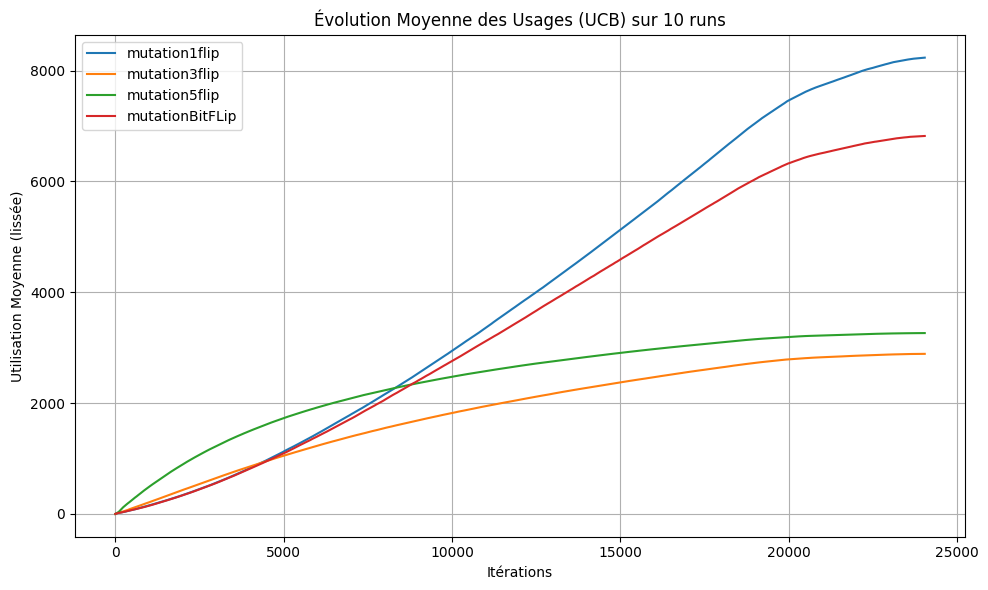

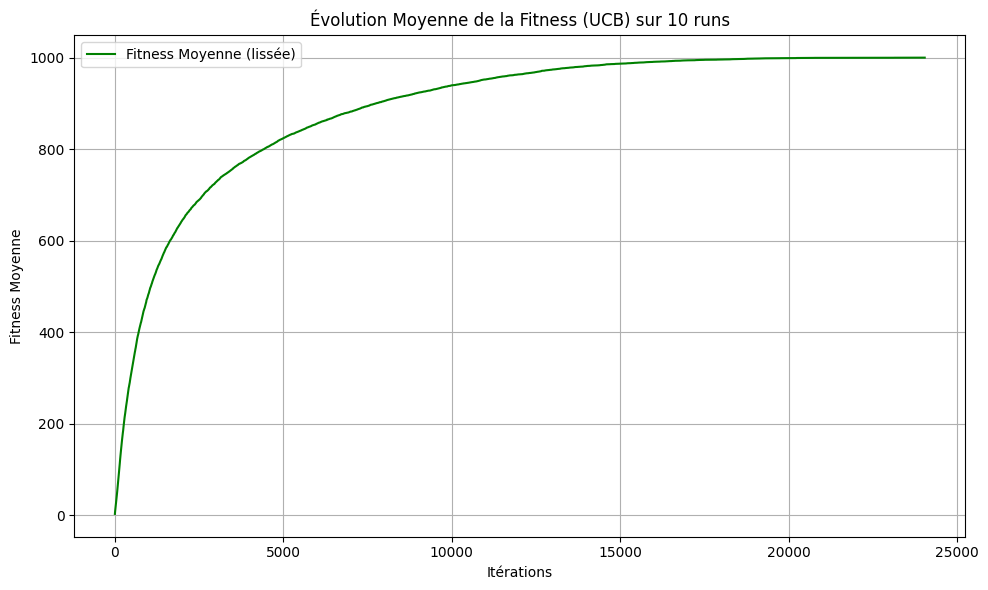

Fichier CSV sauvegardé : csv/UCB.csv


In [6]:
# ================================
# MULTI-RUN + AVERAGING FOR UCB
# ================================

N_RUNS = 10
SMOOTH_WINDOW = 5

def align_nb_eval_histories(all_nb_eval_histories):
    """
    Aligne les historiques de nb_eval pour qu'ils aient tous la même longueur
    en répétant la dernière valeur pour les exécutions plus courtes.
    
    Parameters:
        all_nb_eval_histories (list of list of int): Liste des historiques de nb_eval pour chaque exécution.
    
    Returns:
        numpy.ndarray: Matrice alignée de shape (n_runs, max_length).
    """
    n_runs = len(all_nb_eval_histories)
    max_length = max(len(run) for run in all_nb_eval_histories)
    aligned = np.zeros((n_runs, max_length))
    
    for i, run in enumerate(all_nb_eval_histories):
        for t in range(max_length):
            if t < len(run):
                aligned[i, t] = run[t]
            else:
                aligned[i, t] = run[-1]
    
    return aligned


def run_multiple_evolutions_ucb(n_runs=20):
    """
    Exécute n_runs fois la fonction evolution_with_mutation_test()
    et stocke usage_history et fitness_history de chaque run.
    """
    all_usage_histories = []
    all_fitness_histories = []
    all_nb_eval_histories = []
    
    for run_id in range(n_runs):
        print(f"\n=== Run {run_id+1}/{n_runs} ===")
        ucb_history, usage_history, fitness_history, nb_eval_history = evolution_with_mutation_test()
        
        all_usage_histories.append(usage_history)
        all_fitness_histories.append(fitness_history)
        all_nb_eval_histories.append(nb_eval_history)
    
    return all_usage_histories, all_fitness_histories, all_nb_eval_histories

def align_ucb_histories(all_usage_histories, all_fitness_histories):
    """
    Aligne les runs pour qu'ils aient la même longueur
    en répétant la dernière valeur pour les runs plus courts.
    Retourne:
      usage_histories_aligned : shape (n_runs, max_length, n_operators)
      fitness_histories_aligned : shape (n_runs, max_length)
    """
    import numpy as np

    n_runs = len(all_usage_histories)
    max_length = max(len(u) for u in all_usage_histories)
    n_operators = len(all_usage_histories[0][0]) if max_length > 0 else 0

    usage_histories_aligned = np.zeros((n_runs, max_length, n_operators))
    fitness_histories_aligned = np.zeros((n_runs, max_length))

    for i in range(n_runs):
        usage_run = all_usage_histories[i]
        fitness_run = all_fitness_histories[i]

        T_i = len(usage_run)
        for t in range(max_length):
            if t < T_i:
                usage_histories_aligned[i, t, :] = usage_run[t]
            else:
                usage_histories_aligned[i, t, :] = usage_run[-1]

            if t < len(fitness_run):
                fitness_histories_aligned[i, t] = fitness_run[t]
            else:
                fitness_histories_aligned[i, t] = fitness_run[-1]

    return usage_histories_aligned, fitness_histories_aligned

def smooth_curve(values, window_size=5):
    if window_size < 2:
        return values
    smoothed = []
    for i in range(len(values)):
        start = max(0, i - window_size//2)
        end = min(len(values), i + window_size//2 + 1)
        window = values[start:end]
        smoothed.append(sum(window)/len(window))
    return smoothed

def plot_average_ucb_results(usage_histories_aligned, fitness_histories_aligned, operator_names, smooth_window=5):
    import numpy as np

    n_runs, max_length, n_operators = usage_histories_aligned.shape

    # Moyenne sur l'axe des runs
    mean_usage = np.mean(usage_histories_aligned, axis=0)     # shape (max_length, n_operators)
    mean_fitness = np.mean(fitness_histories_aligned, axis=0) # shape (max_length,)

    # Lissage usage
    usage_smoothed = []
    for op_idx in range(n_operators):
        usage_vals = mean_usage[:, op_idx].tolist()
        usage_vals_smooth = smooth_curve(usage_vals, window_size=smooth_window)
        usage_smoothed.append(usage_vals_smooth)
    usage_smoothed = np.array(usage_smoothed).T

    # Lissage fitness
    fitness_smoothed = smooth_curve(mean_fitness.tolist(), window_size=smooth_window)

    # Plot usage
    iterations = range(max_length)
    plt.figure(figsize=(10,6))
    for op_idx, op_name in enumerate(operator_names):
        plt.plot(iterations, usage_smoothed[:, op_idx], label=op_name)
    plt.xlabel("Itérations")
    plt.ylabel("Utilisation Moyenne (lissée)")
    plt.title("Évolution Moyenne des Usages (UCB) sur {} runs".format(n_runs))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot fitness
    plt.figure(figsize=(10,6))
    plt.plot(iterations, fitness_smoothed, label='Fitness Moyenne (lissée)', color='green')
    plt.xlabel("Itérations")
    plt.ylabel("Fitness Moyenne")
    plt.title("Évolution Moyenne de la Fitness (UCB) sur {} runs".format(n_runs))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
import os
import pandas as pd

def save_ucb_fitness_to_csv(fitness_histories_aligned, mean_nb_eval_smoothed,
                            folder="csv", 
                            filename="UCB.csv", 
                            smooth_window=5):
    """
    Sauvegarde la fitness moyenne et le nb_eval moyen dans un fichier CSV.

    Parameters:
        fitness_histories_aligned (numpy.ndarray): Historique aligné de la fitness.
        mean_nb_eval_smoothed (list of float): Historique moyenné et lissé de nb_eval.
        folder (str): Dossier de sauvegarde.
        filename (str): Nom du fichier CSV.
        smooth_window (int): Taille de la fenêtre de lissage.
    """
    # Appliquer le lissage à la fitness
    mean_fitness = np.mean(fitness_histories_aligned, axis=0)
    fitness_smoothed = smooth_curve(mean_fitness.tolist(), window_size=smooth_window)

    max_length = len(fitness_smoothed)
    
    # S'assurer que nb_eval est de la même longueur que fitness
    if len(mean_nb_eval_smoothed) < max_length:
        # Remplir avec la dernière valeur si nécessaire
        last_value = mean_nb_eval_smoothed[-1]
        mean_nb_eval_smoothed += [last_value] * (max_length - len(mean_nb_eval_smoothed))
    elif len(mean_nb_eval_smoothed) > max_length:
        # Tronquer si nécessaire
        mean_nb_eval_smoothed = mean_nb_eval_smoothed[:max_length]
    
    # Construire un DataFrame avec generation, fitness et nb_eval
    data = {
        "generation": list(range(max_length)),
        "fitness": fitness_smoothed,
        "nb_eval": mean_nb_eval_smoothed
    }
    df = pd.DataFrame(data)
    
    # Créer le dossier s'il n'existe pas
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Sauvegarder en CSV
    filepath = os.path.join(folder, filename)
    df.to_csv(filepath, index=False)
    print(f"Fichier CSV sauvegardé : {filepath}")



def main():
    # Suppose operator_names is from your operator_matrix
    operator_names = [row["operator"] for row in operator_matrix]

    # 1) Exécuter plusieurs évolutions
    all_usage_histories, all_fitness_histories, all_nb_eval_histories = run_multiple_evolutions_ucb(n_runs=N_RUNS)

    # 2) Aligner les historiques de usage et de fitness
    usage_histories_aligned, fitness_histories_aligned = align_ucb_histories(all_usage_histories, all_fitness_histories)

    # 3) Aligner les historiques de nb_eval
    aligned_nb_eval_histories = align_nb_eval_histories(all_nb_eval_histories)

    # 4) Calculer la moyenne de nb_eval par génération
    mean_nb_eval = np.mean(aligned_nb_eval_histories, axis=0)

    # 5) Appliquer le lissage si nécessaire
    mean_nb_eval_smoothed = smooth_curve(mean_nb_eval.tolist(), window_size=SMOOTH_WINDOW)

    # 6) Tracer les résultats moyens
    plot_average_ucb_results(usage_histories_aligned,
                             fitness_histories_aligned,
                             operator_names,
                             smooth_window=SMOOTH_WINDOW)

    # 7) Sauvegarder la fitness et nb_eval moyennes dans un CSV
    save_ucb_fitness_to_csv(fitness_histories_aligned, mean_nb_eval_smoothed,
                            folder="csv",
                            filename="UCB.csv",
                            smooth_window=SMOOTH_WINDOW)
    
if __name__ == "__main__":
    main()

